In [90]:
!pip install seaborn

In [73]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn

In [4]:
DATASET_DIR = 'dataset/'

## Исследование данных (EDA)

In [5]:
classes = sorted(os.listdir(DATASET_DIR))
print(f'Всего классов: {len(classes)}')
print(classes)

Всего классов: 28
['Apple__Healthy', 'Apple__Rotten', 'Banana__Healthy', 'Banana__Rotten', 'Bellpepper__Healthy', 'Bellpepper__Rotten', 'Carrot__Healthy', 'Carrot__Rotten', 'Cucumber__Healthy', 'Cucumber__Rotten', 'Grape__Healthy', 'Grape__Rotten', 'Guava__Healthy', 'Guava__Rotten', 'Jujube__Healthy', 'Jujube__Rotten', 'Mango__Healthy', 'Mango__Rotten', 'Orange__Healthy', 'Orange__Rotten', 'Pomegranate__Healthy', 'Pomegranate__Rotten', 'Potato__Healthy', 'Potato__Rotten', 'Strawberry__Healthy', 'Strawberry__Rotten', 'Tomato__Healthy', 'Tomato__Rotten']


In [6]:
data = []
for class_name in classes:
    class_path = os.path.join(DATASET_DIR, class_name)
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            data.append({
                'path': os.path.join(class_path, fname),
                'label': class_name,
                'fruit': class_name.split('__')[0],
                'status': class_name.split('__')[1]
            })

In [7]:
df = pd.DataFrame(data)
print(df.head(-10))

                                                    path           label  \
0      dataset/Apple__Healthy/saltandpepper_Screen Sh...  Apple__Healthy   
1            dataset/Apple__Healthy/freshApple (645).png  Apple__Healthy   
2      dataset/Apple__Healthy/saltandpepper_Screen Sh...  Apple__Healthy   
3            dataset/Apple__Healthy/FreshApple (141).jpg  Apple__Healthy   
4      dataset/Apple__Healthy/rotated_by_75_Screen Sh...  Apple__Healthy   
...                                                  ...             ...   
29262      dataset/Tomato__Rotten/rottenTomato (156).jpg  Tomato__Rotten   
29263      dataset/Tomato__Rotten/rottenTomato (482).jpg  Tomato__Rotten   
29264       dataset/Tomato__Rotten/rottenTomato (24).jpg  Tomato__Rotten   
29265      dataset/Tomato__Rotten/rottenTomato (576).jpg  Tomato__Rotten   
29266       dataset/Tomato__Rotten/rottenTomato (41).jpg  Tomato__Rotten   

        fruit   status  
0       Apple  Healthy  
1       Apple  Healthy  
2       Appl

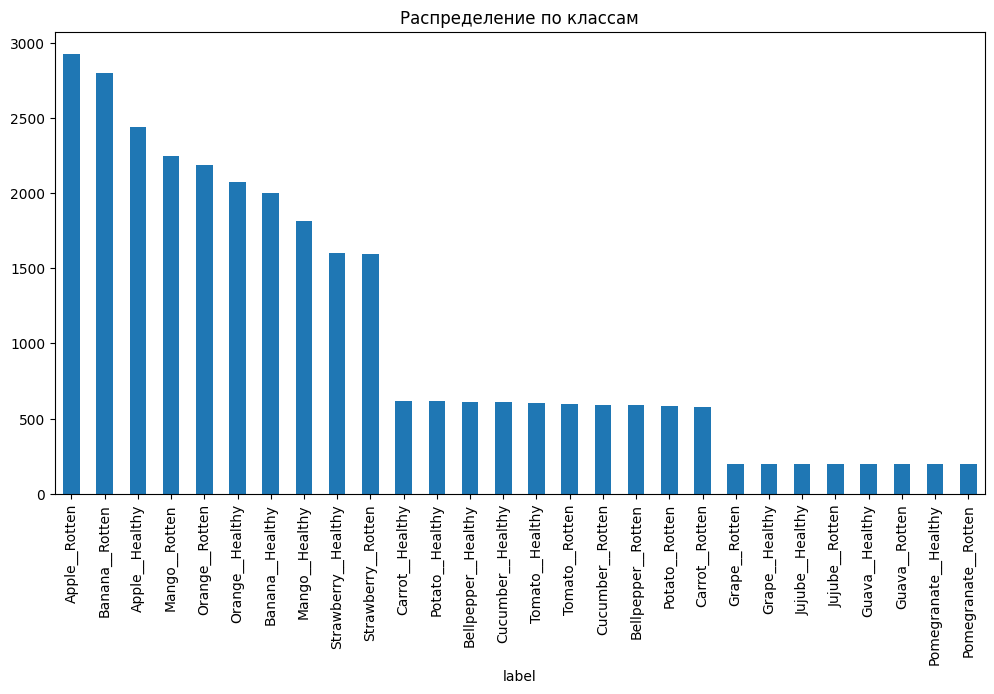

In [8]:
plt.figure(figsize=(12,6))
df['label'].value_counts().plot(kind='bar')
plt.title('Распределение по классам')
plt.show()

## Дисбаланс данных:
На графике видно, что некоторые классы существенно доминируют по количеству изображений. Больше всего примеров у классов Apple__Rotten, Banana__Rotten, Apple__Healthy — по 2000–3000 изображений.
Есть классы с заметно меньшим количеством примеров — Pomegranate__Healthy, Guava__Healthy, Jujube__Rotten и другие имеют менее 300 изображений.

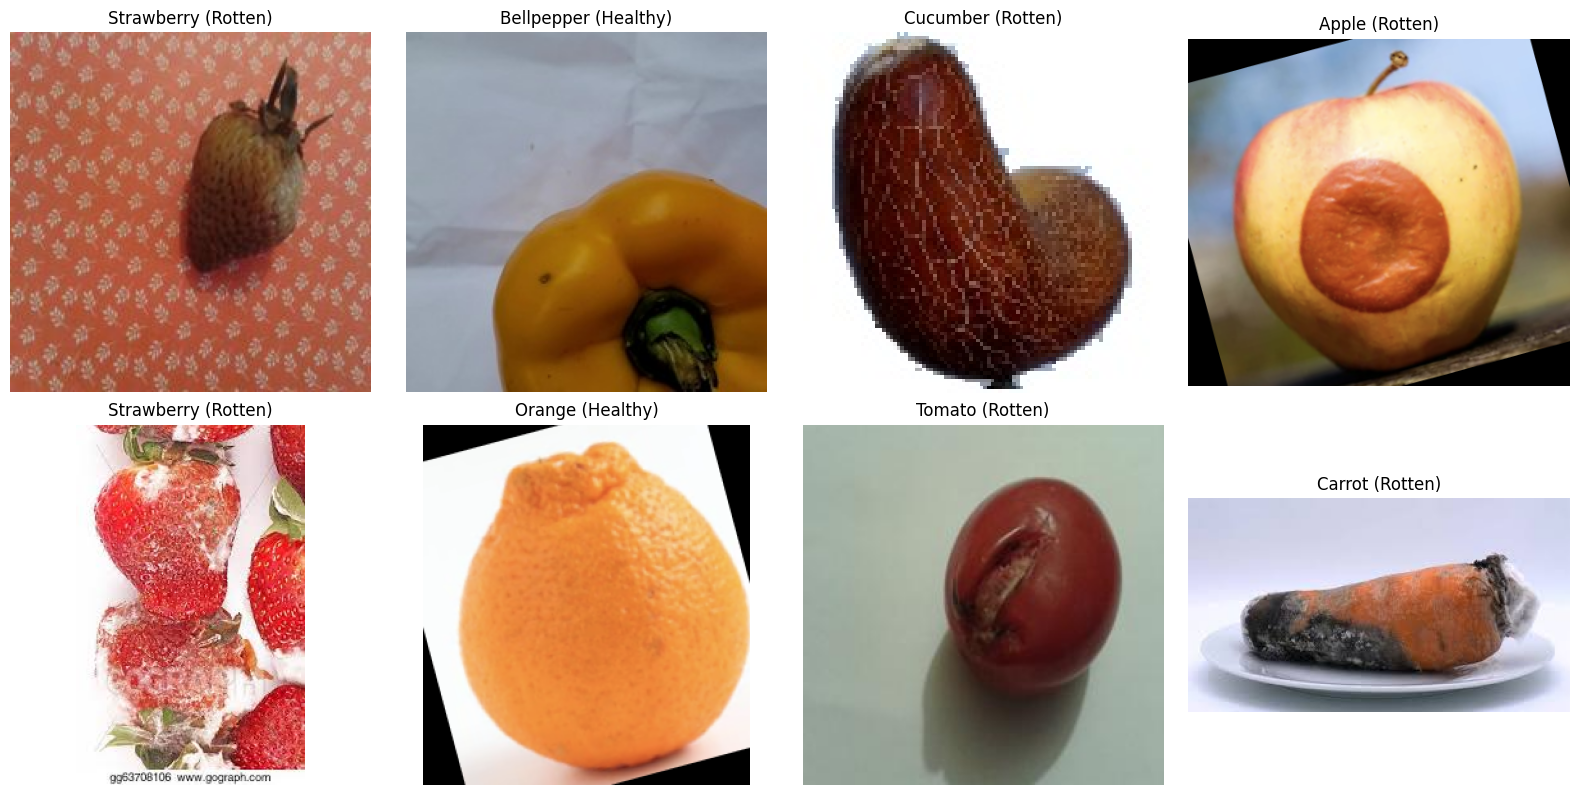

In [9]:
import random
sample = df.sample(8)
fig, axes = plt.subplots(2, 4, figsize=(16,8))
for i, (idx, row) in enumerate(sample.iterrows()):
    img = Image.open(row['path'])
    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].set_title(f"{row['fruit']} ({row['status']})")
    axes[i//4, i%4].axis('off')
plt.tight_layout()
plt.show()

## Разметка train/val/test

In [10]:
from sklearn.model_selection import train_test_split

df['label_id'] = df['label'].astype('category').cat.codes
label2id = dict(zip(df['label'].unique(), df['label_id'].unique()))
id2label = {v: k for k, v in label2id.items()}
print(label2id)

train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label_id'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label_id'], random_state=42
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print("Train баланс:\n", train_df['label'].value_counts())
print("Val баланс:\n", val_df['label'].value_counts())
print("Test баланс:\n", test_df['label'].value_counts())



{'Apple__Healthy': np.int8(0), 'Apple__Rotten': np.int8(1), 'Banana__Healthy': np.int8(2), 'Banana__Rotten': np.int8(3), 'Bellpepper__Healthy': np.int8(4), 'Bellpepper__Rotten': np.int8(5), 'Carrot__Healthy': np.int8(6), 'Carrot__Rotten': np.int8(7), 'Cucumber__Healthy': np.int8(8), 'Cucumber__Rotten': np.int8(9), 'Grape__Healthy': np.int8(10), 'Grape__Rotten': np.int8(11), 'Guava__Healthy': np.int8(12), 'Guava__Rotten': np.int8(13), 'Jujube__Healthy': np.int8(14), 'Jujube__Rotten': np.int8(15), 'Mango__Healthy': np.int8(16), 'Mango__Rotten': np.int8(17), 'Orange__Healthy': np.int8(18), 'Orange__Rotten': np.int8(19), 'Pomegranate__Healthy': np.int8(20), 'Pomegranate__Rotten': np.int8(21), 'Potato__Healthy': np.int8(22), 'Potato__Rotten': np.int8(23), 'Strawberry__Healthy': np.int8(24), 'Strawberry__Rotten': np.int8(25), 'Tomato__Healthy': np.int8(26), 'Tomato__Rotten': np.int8(27)}
Train: 20493, Val: 4392, Test: 4392
Train баланс:
 label
Apple__Rotten           2047
Banana__Rotten     

## Добавление аугментаций

In [11]:
mean = [0.485, 0.456, 0.406]  
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [12]:
class FruitDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['path'])
        if img.mode == 'P' or img.mode == 'RGBA':
            img = img.convert('RGBA').convert('RGB')
        else:
            img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(row['label_id'])
        return img, label

In [13]:
BATCH_SIZE = 32

train_dataset = FruitDataset(train_df, transform=train_transform)
val_dataset = FruitDataset(val_df, transform=val_transform)
test_dataset = FruitDataset(test_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [14]:
images, labels = next(iter(train_loader))

def denormalize(img_tensor, mean=mean, std=std):
    img = img_tensor.clone().cpu()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

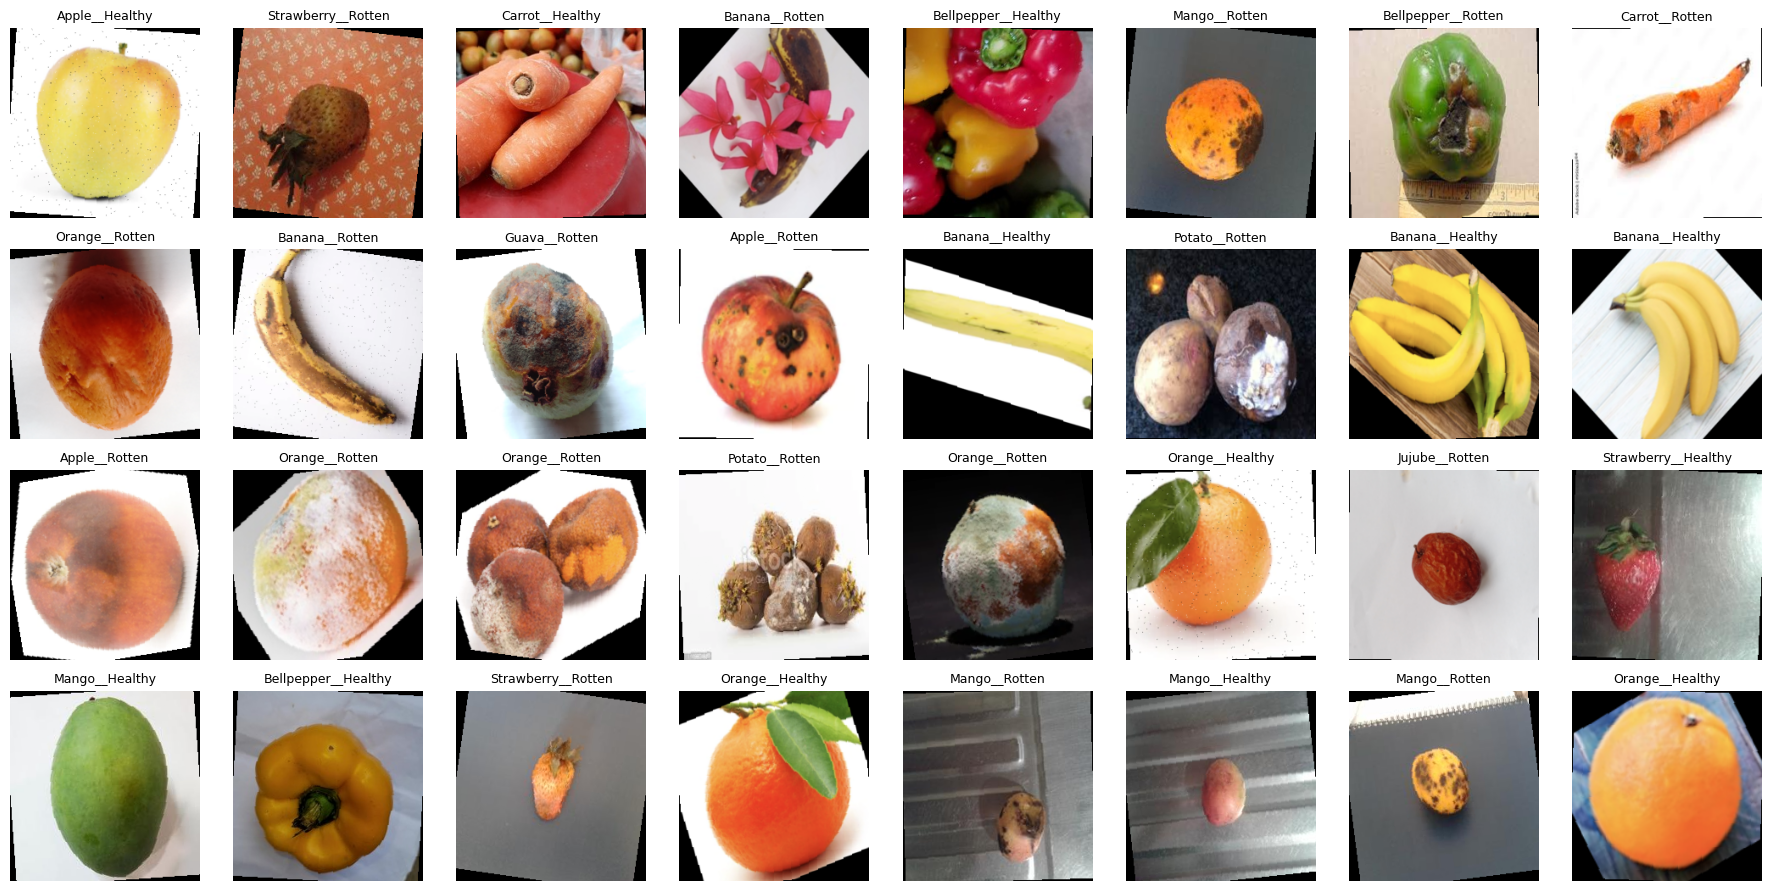

In [15]:
labels_text = [id2label[l.item()] for l in labels]

fig, axes = plt.subplots(4, 8, figsize=(18, 9))
for i in range(32):  # BATCH_SIZE=32
    ax = axes[i//8, i%8]
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(labels_text[i], fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Тестирование моделей

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Тестирование модели ResNet18

In [17]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 28)

model = model.to(device)

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
from utils.trainer import train_model

history = train_model(
    model,
    train_loader=train_loader,
    test_loader=val_loader,
    epochs=20,      
    lr=1e-4, 
    device=device,
    patience=3,  
    save_path='best_vegetables_resnet18.pth'
)

100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:14<00:00,  9.82it/s]


Epoch 1/20:
Train Loss: 0.3689, Train Acc: 0.9074
Test Loss: 0.0946, Test Acc: 0.9740
--------------------------------------------------
Best model saved with acc 0.9740


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:15<00:00,  8.76it/s]


Epoch 2/20:
Train Loss: 0.0937, Train Acc: 0.9732
Test Loss: 0.1003, Test Acc: 0.9690
--------------------------------------------------
No improvement for 1 epochs


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:16<00:00,  8.56it/s]


Epoch 3/20:
Train Loss: 0.0609, Train Acc: 0.9819
Test Loss: 0.0686, Test Acc: 0.9781
--------------------------------------------------
Best model saved with acc 0.9781


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:15<00:00,  8.82it/s]


Epoch 4/20:
Train Loss: 0.0442, Train Acc: 0.9879
Test Loss: 0.0730, Test Acc: 0.9777
--------------------------------------------------
No improvement for 1 epochs


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:13<00:00, 10.24it/s]


Epoch 5/20:
Train Loss: 0.0394, Train Acc: 0.9892
Test Loss: 0.0613, Test Acc: 0.9825
--------------------------------------------------
Best model saved with acc 0.9825


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:14<00:00,  9.85it/s]


Epoch 6/20:
Train Loss: 0.0333, Train Acc: 0.9906
Test Loss: 0.0794, Test Acc: 0.9786
--------------------------------------------------
No improvement for 1 epochs


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:12<00:00, 10.79it/s]


Epoch 7/20:
Train Loss: 0.0320, Train Acc: 0.9909
Test Loss: 0.1009, Test Acc: 0.9736
--------------------------------------------------
No improvement for 2 epochs


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:12<00:00, 10.78it/s]

Epoch 8/20:
Train Loss: 0.0231, Train Acc: 0.9933
Test Loss: 0.0851, Test Acc: 0.9770
--------------------------------------------------
No improvement for 3 epochs
Early stopping triggered at epoch 8


### Best model saved with acc 0.9825

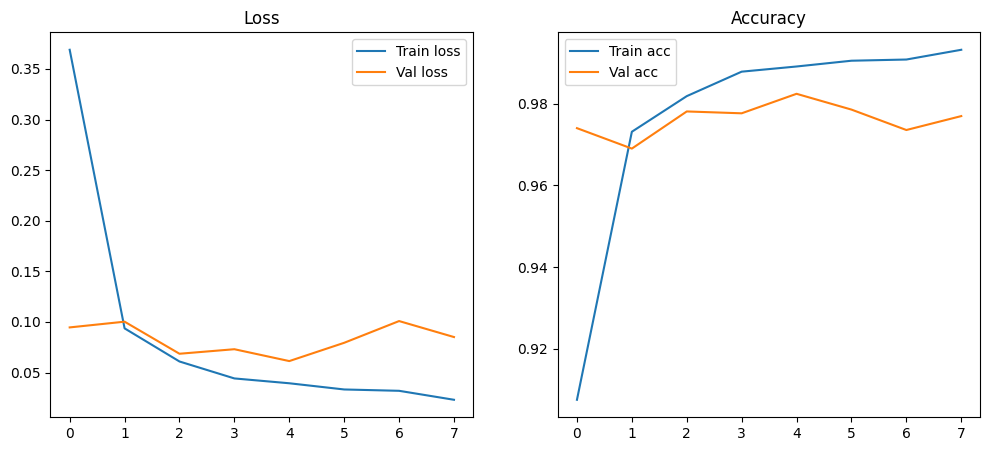

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_losses'], label='Train loss')
plt.plot(history['test_losses'], label='Val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['train_accs'], label='Train acc')
plt.plot(history['test_accs'], label='Val acc')
plt.legend()
plt.title('Accuracy')

plt.show()

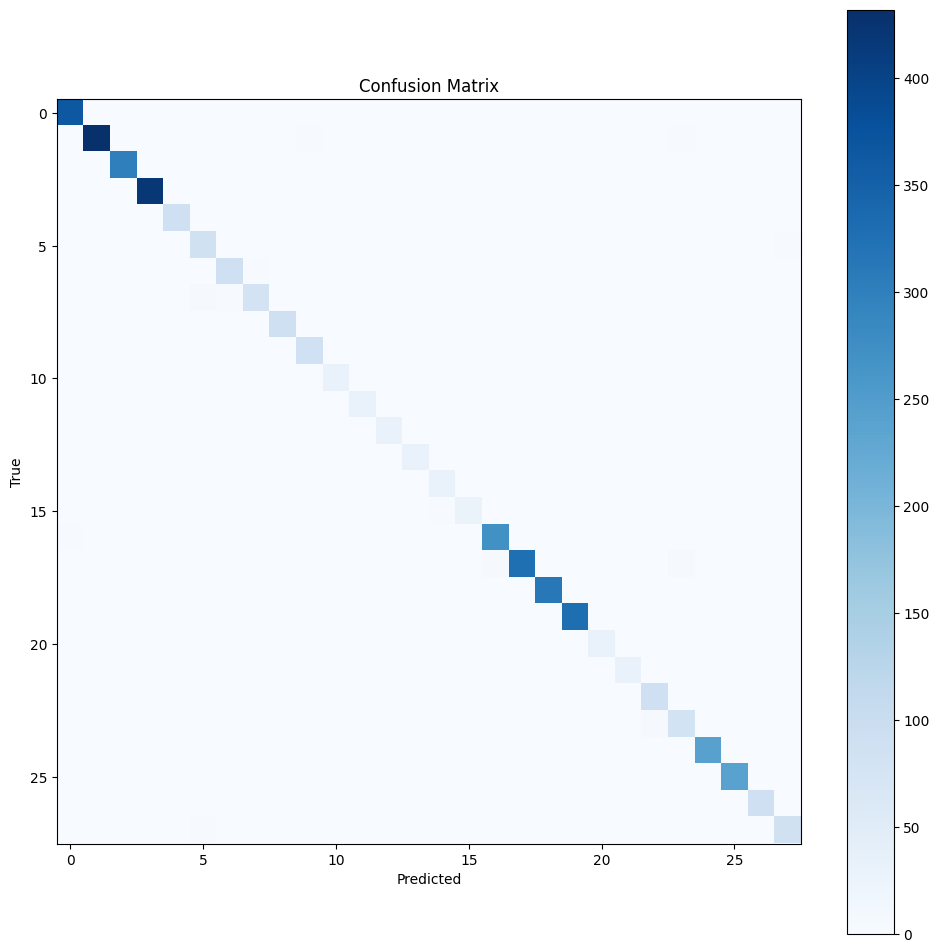

In [94]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(12,12))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

                      precision    recall  f1-score   support

      Apple__Healthy       0.99      0.99      0.99       365
       Apple__Rotten       0.98      0.97      0.98       439
     Banana__Healthy       1.00      0.99      1.00       300
      Banana__Rotten       1.00      1.00      1.00       419
 Bellpepper__Healthy       0.97      0.96      0.96        92
  Bellpepper__Rotten       0.74      0.85      0.79        89
     Carrot__Healthy       0.93      0.91      0.92        93
      Carrot__Rotten       0.78      0.92      0.84        87
   Cucumber__Healthy       0.97      0.97      0.97        91
    Cucumber__Rotten       0.92      0.92      0.92        89
      Grape__Healthy       0.97      1.00      0.98        30
       Grape__Rotten       1.00      0.97      0.98        30
      Guava__Healthy       1.00      1.00      1.00        30
       Guava__Rotten       1.00      0.97      0.98        30
     Jujube__Healthy       0.94      1.00      0.97        30
      J

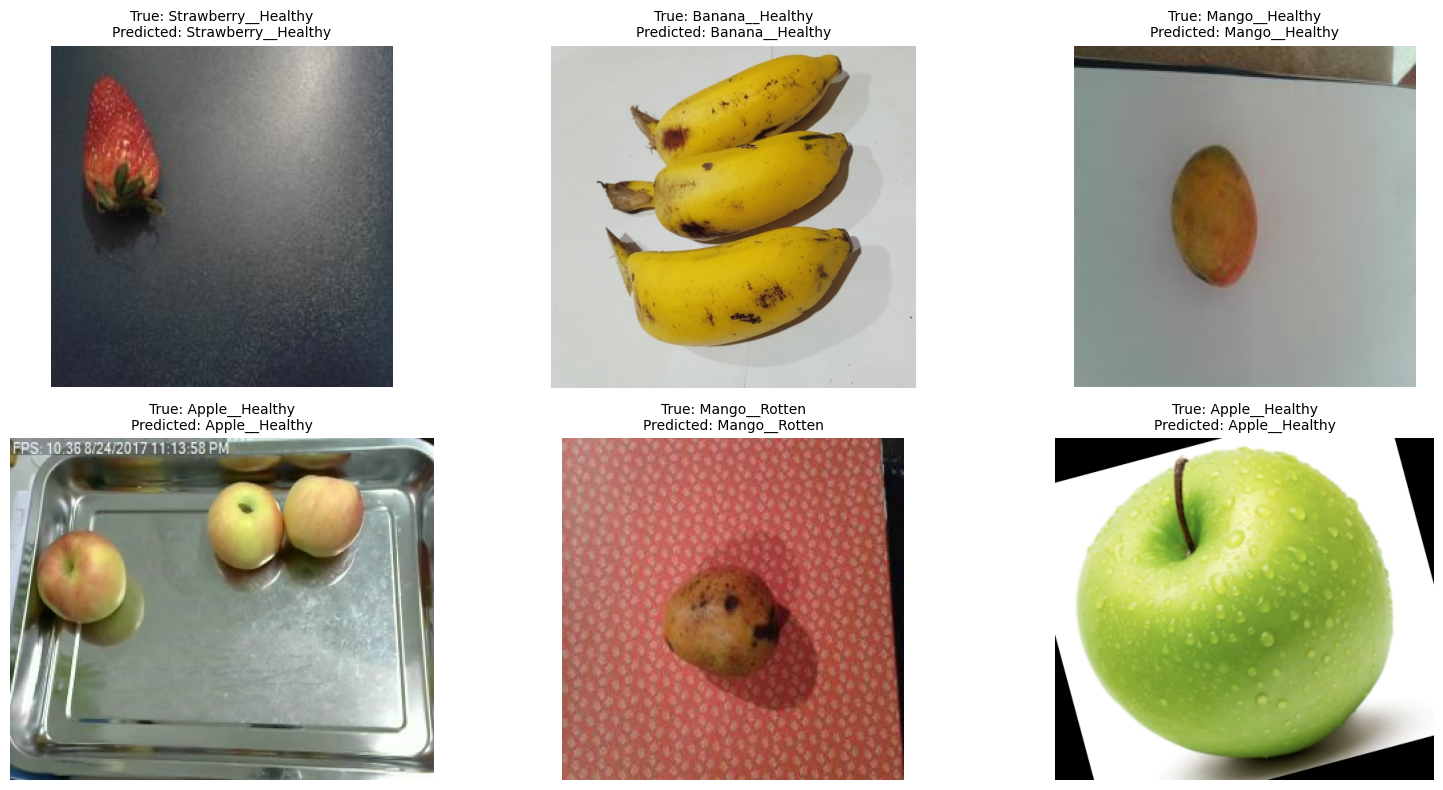

In [26]:
import random
import matplotlib.pyplot as plt

# 6 случайных примеров из тестовой выборки
n = 6
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for i in range(n):
    idx = random.randint(0, len(test_df)-1)
    row = test_df.iloc[idx]
    img_path = row['path']
    true_label = row['label']

    img = Image.open(img_path).convert('RGB')
    input_tensor = val_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(1).item()
        pred_label = id2label[pred]

    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Обучение на основе модели EfficientNet-B0

In [ ]:
model_effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
num_ftrs = model_effnet.classifier[1].in_features
model_effnet.classifier[1] = nn.Linear(num_ftrs, 28)
model_effnet = model_effnet.to(device)

In [78]:
history_effnet = train_model(
    model_effnet,
    train_loader=train_loader,
    test_loader=val_loader,
    epochs=20,
    lr=1e-4,
    device=device,
    patience=3,
    save_path='best_vegetables_effnetb0.pth'
)

100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:15<00:00,  9.06it/s]


Epoch 1/20:
Train Loss: 0.0637, Train Acc: 0.9818
Test Loss: 0.0483, Test Acc: 0.9852
--------------------------------------------------
Best model saved with acc 0.9852


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:13<00:00,  9.91it/s]


Epoch 2/20:
Train Loss: 0.0408, Train Acc: 0.9878
Test Loss: 0.0453, Test Acc: 0.9854
--------------------------------------------------
Best model saved with acc 0.9854


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:12<00:00, 11.02it/s]


Epoch 3/20:
Train Loss: 0.0315, Train Acc: 0.9909
Test Loss: 0.0412, Test Acc: 0.9891
--------------------------------------------------
Best model saved with acc 0.9891


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:12<00:00, 11.35it/s]


Epoch 4/20:
Train Loss: 0.0255, Train Acc: 0.9919
Test Loss: 0.0480, Test Acc: 0.9845
--------------------------------------------------
No improvement for 1 epochs


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:13<00:00, 10.25it/s]


Epoch 5/20:
Train Loss: 0.0216, Train Acc: 0.9933
Test Loss: 0.0448, Test Acc: 0.9866
--------------------------------------------------
No improvement for 2 epochs


100%|█████████████████████████████████████████████████████████████████████████████████| 138/138 [00:13<00:00, 10.03it/s]

Epoch 6/20:
Train Loss: 0.0192, Train Acc: 0.9939
Test Loss: 0.0477, Test Acc: 0.9868
--------------------------------------------------
No improvement for 3 epochs
Early stopping triggered at epoch 6


### Best model saved with acc 0.9891

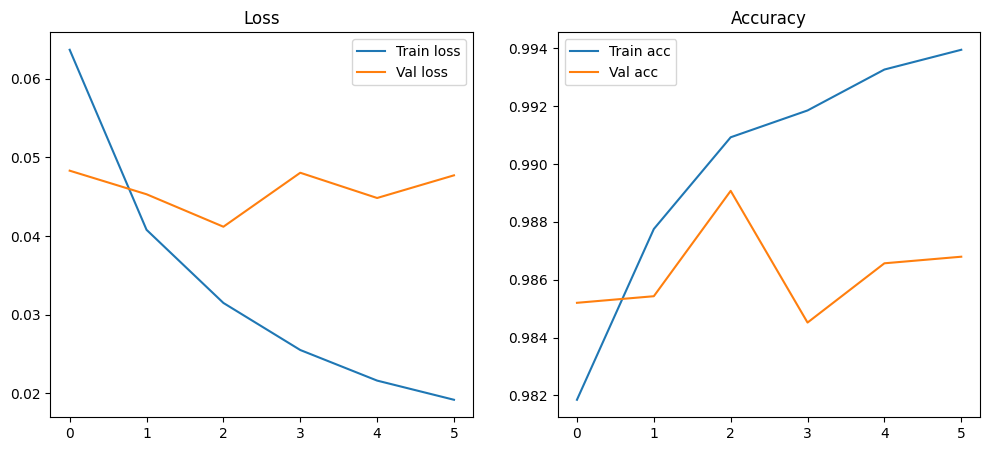

In [79]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_effnet['train_losses'], label='Train loss')
plt.plot(history_effnet['test_losses'], label='Val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history_effnet['train_accs'], label='Train acc')
plt.plot(history_effnet['test_accs'], label='Val acc')
plt.legend()
plt.title('Accuracy')

plt.show()

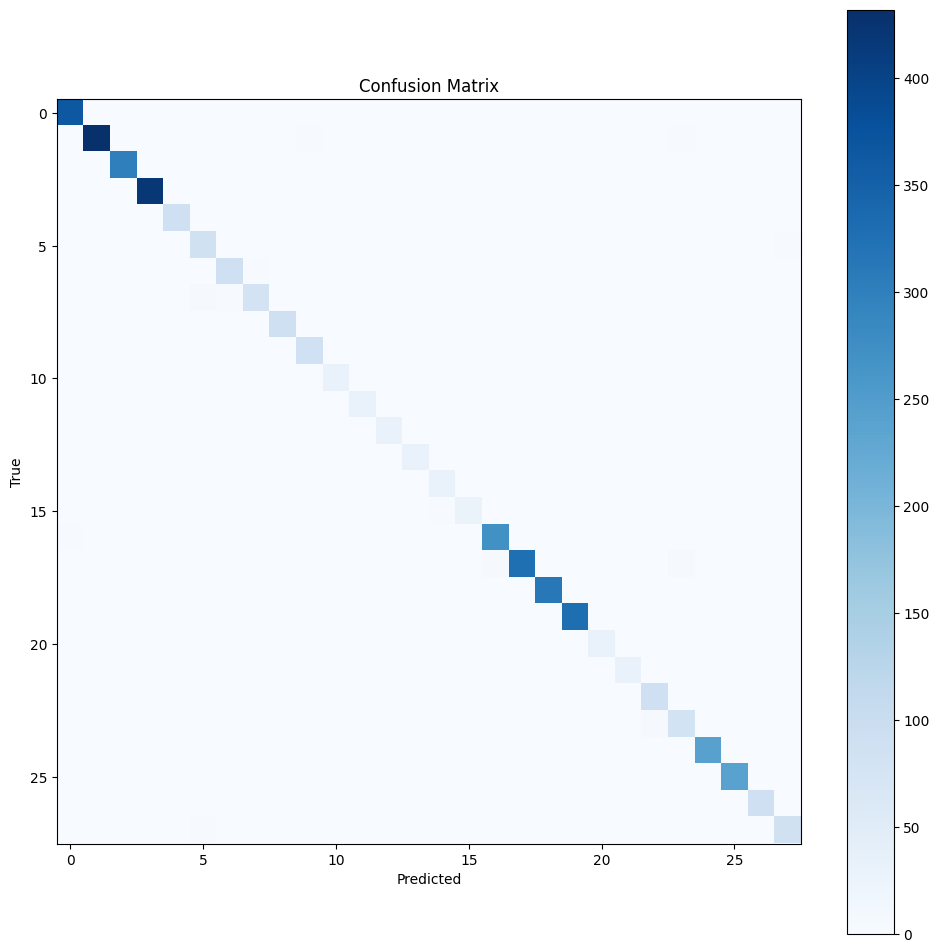

In [95]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()
all_preds_eff = []
all_targets_eff = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds_eff.append(preds.cpu().numpy())
        all_targets_eff.append(labels.cpu().numpy())

all_preds_eff = np.concatenate(all_preds_eff)
all_targets_eff = np.concatenate(all_targets_eff)

cm = confusion_matrix(all_targets_eff, all_preds_eff)
plt.figure(figsize=(12,12))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
import matplotlib.pyplot as plt

In [81]:
print(classification_report(all_targets_eff, all_preds_eff, target_names=[id2label[i] for i in range(28)]))

                      precision    recall  f1-score   support

      Apple__Healthy       0.99      1.00      0.99       365
       Apple__Rotten       1.00      0.98      0.99       439
     Banana__Healthy       1.00      1.00      1.00       300
      Banana__Rotten       1.00      1.00      1.00       419
 Bellpepper__Healthy       0.99      0.98      0.98        92
  Bellpepper__Rotten       0.89      0.97      0.92        89
     Carrot__Healthy       0.96      0.95      0.95        93
      Carrot__Rotten       0.94      0.90      0.92        87
   Cucumber__Healthy       0.98      1.00      0.99        91
    Cucumber__Rotten       0.97      0.98      0.97        89
      Grape__Healthy       0.97      1.00      0.98        30
       Grape__Rotten       1.00      0.97      0.98        30
      Guava__Healthy       1.00      1.00      1.00        30
       Guava__Rotten       0.97      1.00      0.98        30
     Jujube__Healthy       0.91      1.00      0.95        30
      J

### Модель EfficientNet-B0 показала очень хорошие результаты на каждом из фруктов/овощей.

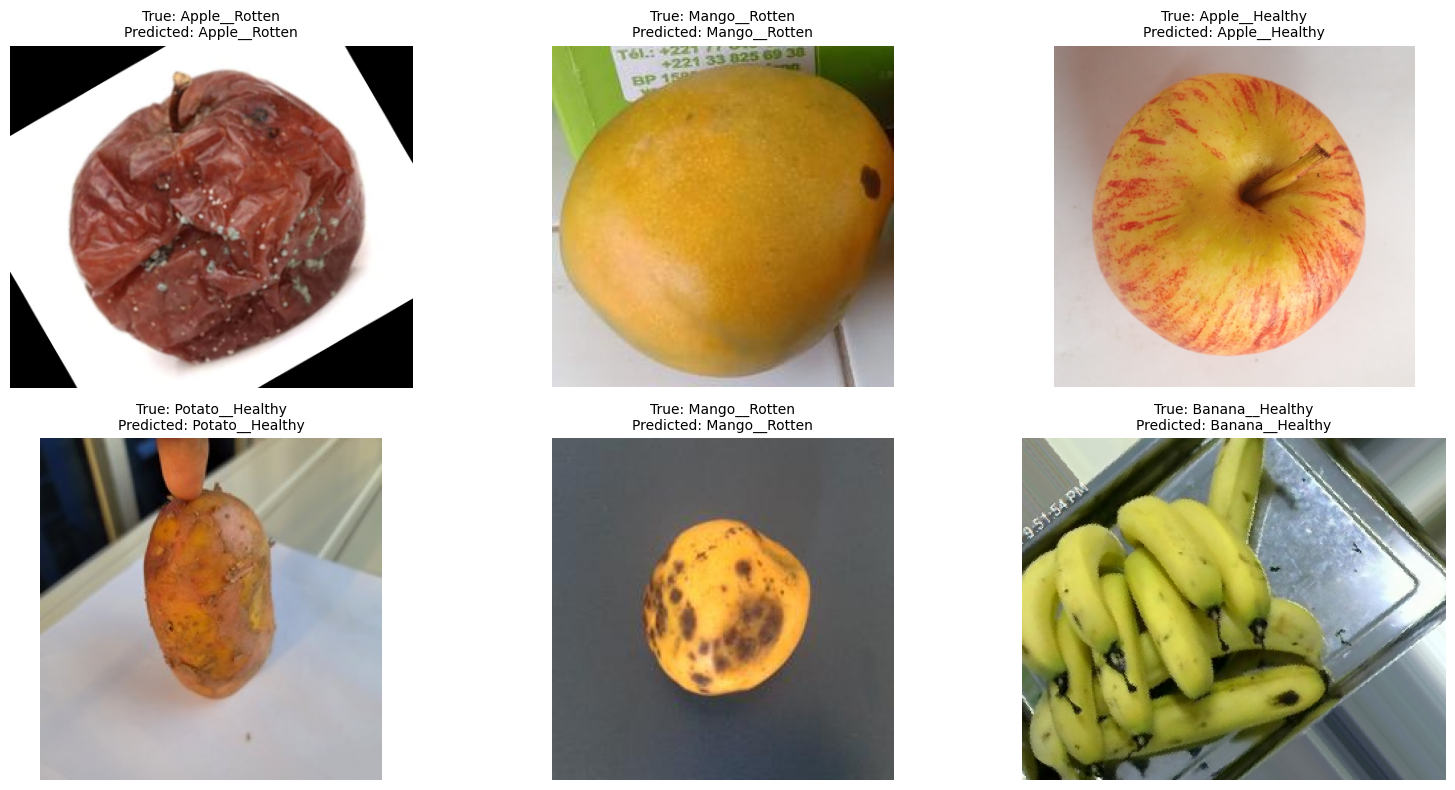

In [82]:
n = 6
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for i in range(n):
    idx = random.randint(0, len(test_df)-1)
    row = test_df.iloc[idx]
    img_path = row['path']
    true_label = row['label']

    img = Image.open(img_path).convert('RGB')
    input_tensor = val_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(1).item()
        pred_label = id2label[pred]

    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [40]:
model_resnet = models.resnet18(weights=None)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 28)
model_resnet.load_state_dict(torch.load('best_vegetables_resnet18.pth', map_location=device))
model_resnet = model_resnet.to(device)
model_resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [83]:
def get_all_preds(model, loader, device='cpu'):
    all_preds = []
    all_targets = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(labels.numpy())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    return all_preds, all_targets

all_preds_resnet, all_targets_resnet = get_all_preds(model_resnet, test_loader, device)

In [84]:
from sklearn.metrics import classification_report
import pandas as pd

classes = [id2label[i] for i in range(28)]

report_resnet = classification_report(all_targets_resnet, all_preds_resnet, target_names=classes, output_dict=True)
report_eff = classification_report(all_targets_eff, all_preds_eff, target_names=classes, output_dict=True)

df_compare = pd.DataFrame({
    'Class': classes,
    'F1_ResNet18': [report_resnet[c]['f1-score'] for c in classes],
    'F1_EffNetB0': [report_eff[c]['f1-score'] for c in classes],
    'Precision_ResNet18': [report_resnet[c]['precision'] for c in classes],
    'Precision_EffNetB0': [report_eff[c]['precision'] for c in classes],
    'Recall_ResNet18': [report_resnet[c]['recall'] for c in classes],
    'Recall_EffNetB0': [report_eff[c]['recall'] for c in classes],
    'Support': [report_resnet[c]['support'] for c in classes],
})

df_compare['F1_diff'] = df_compare['F1_EffNetB0'] - df_compare['F1_ResNet18']

print(df_compare.head(10))

                 Class  F1_ResNet18  F1_EffNetB0  Precision_ResNet18  \
0       Apple__Healthy     0.993160     0.994550            0.991803   
1        Apple__Rotten     0.984127     0.990826            0.979684   
2      Banana__Healthy     0.995008     0.998331            0.993355   
3       Banana__Rotten     0.998805     1.000000            1.000000   
4  Bellpepper__Healthy     0.983784     0.983607            0.978495   
5   Bellpepper__Rotten     0.858896     0.924731            0.945946   
6      Carrot__Healthy     0.950276     0.951351            0.977273   
7       Carrot__Rotten     0.891304     0.917647            0.845361   
8    Cucumber__Healthy     0.978495     0.989130            0.957895   
9     Cucumber__Rotten     0.959064     0.972067            1.000000   

   Precision_EffNetB0  Recall_ResNet18  Recall_EffNetB0  Support   F1_diff  
0            0.989160         0.994521         1.000000    365.0  0.001390  
1            0.997691         0.988610         0.9840

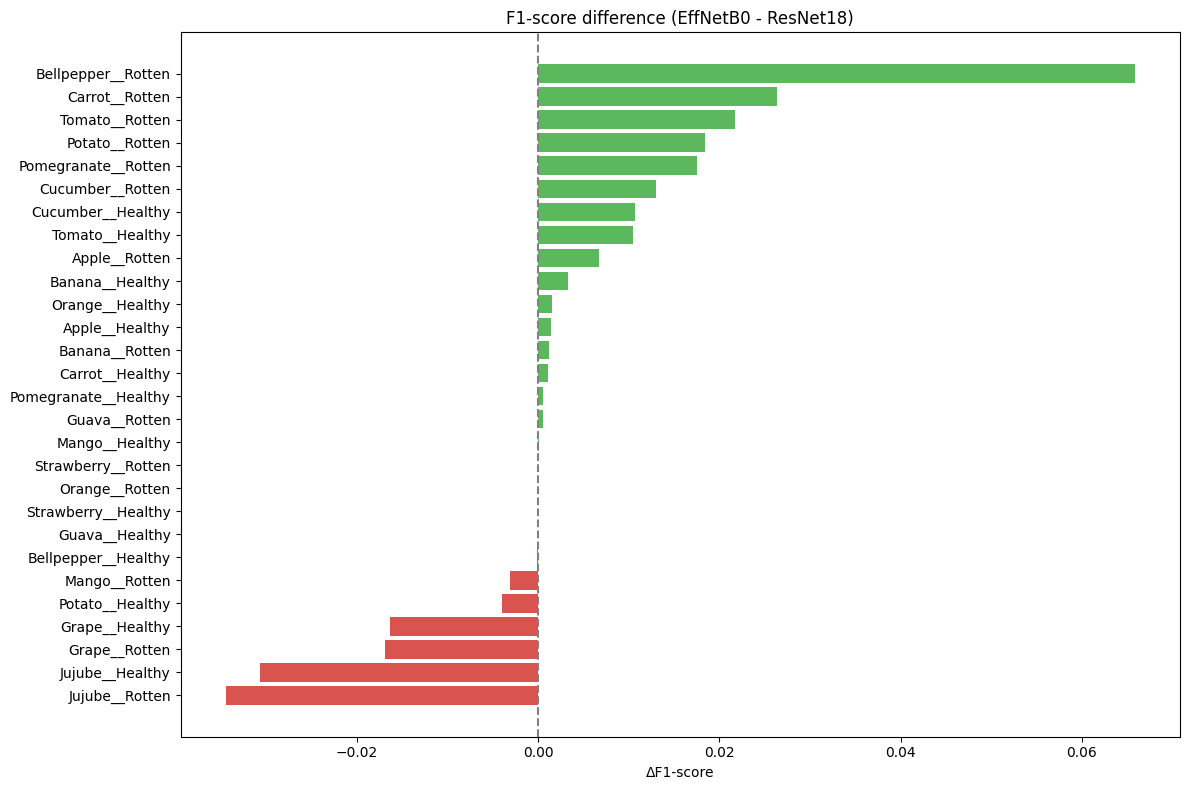

In [85]:
import matplotlib.pyplot as plt
import numpy as np

df_sorted = df_compare.sort_values('F1_diff')

plt.figure(figsize=(12,8))
plt.barh(df_sorted['Class'], df_sorted['F1_diff'], color=['#d9534f' if x < 0 else '#5cb85c' for x in df_sorted['F1_diff']])
plt.axvline(0, color='gray', linestyle='--')
plt.title('F1-score difference (EffNetB0 - ResNet18)')
plt.xlabel('ΔF1-score')
plt.tight_layout()
plt.show()

### В большинстве случаев EffNet показывает себя в большинстве случаев сильно лучше